In [15]:
import pandas as pd
import os
import re

# Path to your CSV (this is correct as you mentioned)
CSV_PATH = 'artifact_dataset/metadata.csv'

# 1) Read the CSV
df = pd.read_csv(CSV_PATH)
print("Dataframe after reading CSV:")
print(df.head())  # Inspect raw data

# 2) Strip whitespace from columns
df['ArtifactType'] = df['ArtifactType'].str.strip()
df['Name'] = df['Name'].str.strip()
df['Age'] = df['Age'].str.strip()
df['Image'] = df['Image'].str.strip()

print("\nDataframe after cleaning columns:")
print(df.head())

# 3) Parse Age column with regex (example approach)
def parse_age(age_str):
    if isinstance(age_str, str):
        # Match range: e.g., "920-970 AD", "100BCE-10AD"
        match_range = re.match(r'(\d+)-(\d+)\s*(AD|BCE)?', age_str)
        if match_range:
            start, end, era = match_range.groups()
            start, end = int(start), int(end)
            # Return average (simplistic approach)
            return (start + end) / 2.0
        
        # Match single year: e.g., "AD 500", "100 BCE"
        match_single = re.match(r'(?:AD|BCE)?\s*(\d+)', age_str)
        if match_single:
            value = match_single.group(1)
            return float(value)
        
        # If nothing matches, return None
        return None
    return None

df['Age'] = df['Age'].apply(parse_age)
print("\nParsed Age values:")
print(df['Age'].head())

# 4) Check if Image paths exist
df['Image'] = df['Image'].fillna('')
df['file_exists'] = df['Image'].apply(lambda x: os.path.exists(x))

# Show the first few paths
print("\nChecking first few image paths:")
for path in df['Image'].head(5):
    print(f"{path} - Exists? {os.path.exists(path)}")

# 5) Filter rows: valid Age + existing file
df_clean = df[df['Age'].notna() & df['file_exists']]

print("\nDataframe after filtering invalid rows:")
print(df_clean.head())
print("\nTotal valid images:", len(df_clean))

# 6) Save cleaned dataset
df_clean.drop(columns='file_exists', inplace=True)  # remove helper column
df_clean.to_csv("cleaned_dataset.csv", index=False)
print("\nCleaned dataset saved as cleaned_dataset.csv")


Dataframe after reading CSV:
  ArtifactType  Name           Age                                    Image
0         coin  Coin    920-970 AD  artifact_dataset/images/coin/457627.jpg
1         coin  Coin   958-1008 AD  artifact_dataset/images/coin/457133.jpg
2         coin  Coin    755-815 AD  artifact_dataset/images/coin/457626.jpg
3         coin  Coin  1074-1124 AD  artifact_dataset/images/coin/457275.jpg
4         coin  Coin    758-808 AD  artifact_dataset/images/coin/457209.jpg

Dataframe after cleaning columns:
  ArtifactType  Name           Age                                    Image
0         coin  Coin    920-970 AD  artifact_dataset/images/coin/457627.jpg
1         coin  Coin   958-1008 AD  artifact_dataset/images/coin/457133.jpg
2         coin  Coin    755-815 AD  artifact_dataset/images/coin/457626.jpg
3         coin  Coin  1074-1124 AD  artifact_dataset/images/coin/457275.jpg
4         coin  Coin    758-808 AD  artifact_dataset/images/coin/457209.jpg

Parsed Age values:
0   

In [16]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Read the cleaned CSV
df = pd.read_csv("cleaned_dataset.csv")
print("Cleaned DataFrame head:")
print(df.head())

# Set parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 20

# Set up data augmentation with a validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,          # 20% of data for validation
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# If the 'Image' column already contains full relative paths (e.g., "artifact_dataset/images/coin/457627.jpg"),
# we set directory="" so that flow_from_dataframe uses the path directly.
# Otherwise, if it only contains filenames (e.g., "457627.jpg"), then set directory to the base folder
# that contains the subfolders (e.g., directory="artifact_dataset/images").
# Adjust the following parameter as needed:
DIRECTORY = ''  

# Create the training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="Image",
    y_col="Age",
    directory=DIRECTORY,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset="training",
    class_mode='raw'  # for regression
)

# Create the validation generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="Image",
    y_col="Age",
    directory=DIRECTORY,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset="validation",
    class_mode='raw'
)

# Build the model using transfer learning (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='linear')(x)  # Single neuron for regression output (Age)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mae'])
model.summary()

# Callbacks: using a .keras extension for ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("artifact_date_model.keras", monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Optional fine-tuning: unfreeze the last 20 layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=['mae'])

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save the final model
model.save("final_artifact_date_model.keras")
print("Training complete. Final model saved as final_artifact_date_model.keras")


Cleaned DataFrame head:
  ArtifactType  Name     Age                                    Image
0         coin  Coin   945.0  artifact_dataset/images/coin/457627.jpg
1         coin  Coin   983.0  artifact_dataset/images/coin/457133.jpg
2         coin  Coin   785.0  artifact_dataset/images/coin/457626.jpg
3         coin  Coin  1099.0  artifact_dataset/images/coin/457275.jpg
4         coin  Coin   783.0  artifact_dataset/images/coin/457209.jpg
Found 741 validated image filenames.
Found 185 validated image filenames.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - loss: 922648.6250 - mae: 924.3391 - val_loss: 847593.0000 - val_mae: 904.7307
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 919643.5625 - mae: 929.1882 - val_loss: 846586.3125 - val_mae: 904.1733
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 913414.4375 - mae: 920.8171 - val_loss: 845582.9375 - val_mae: 903.6173
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 920850.3750 - mae: 927.0832 - val_loss: 844578.6250 - val_mae: 903.0621
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 907376.9375 - mae: 916.7670 - val_loss: 843588.6875 - val_mae: 902.5118
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 925976.1250 - mae: 929.8337 - val_loss: 842588.8125 - val_mae: 901.9565
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 921438.2500 - mae: 926.9994 - val_loss: 841582.1250 - val_mae: 901.3995
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 918458.9375 - mae: 923.9879 - val_loss: 840

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming cleaned_dataset.csv is your cleaned data
df = pd.read_csv("cleaned_dataset.csv")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,            # your test dataframe
    x_col="Image",                # adjust if needed
    y_col="Age",
    directory="",                 # or set appropriate directory if relative paths are used
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

results = model.evaluate(test_generator)
print("Test Loss:", results[0])
print("Test MAE:", results[1])


Found 186 validated image filenames.


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 785394.6250 - mae: 862.6710
Test Loss: 791675.0
Test MAE: 862.8796997070312


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Age: 34.41652


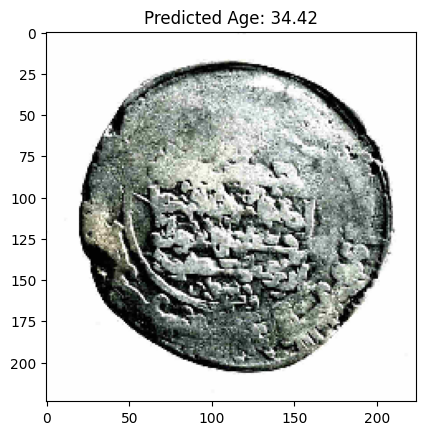

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "artifact_dataset/images/coin/457172.jpg"  # example image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
print("Predicted Age:", pred[0][0])

plt.imshow(img)
plt.title("Predicted Age: {:.2f}".format(pred[0][0]))
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


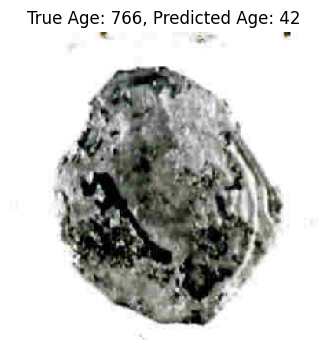

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


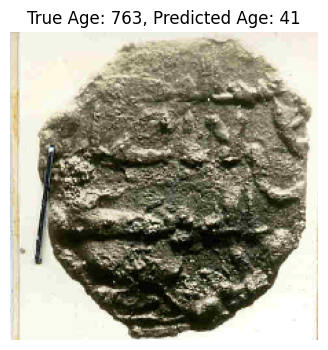

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


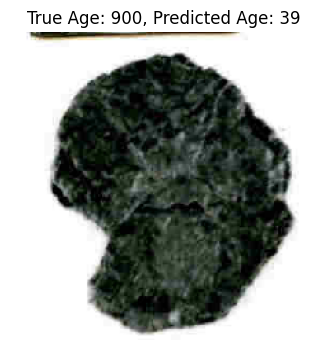

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


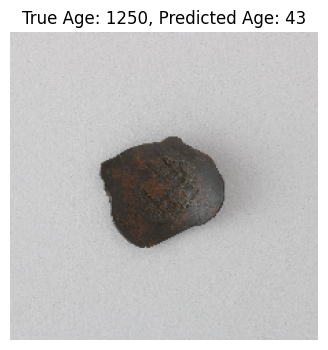

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


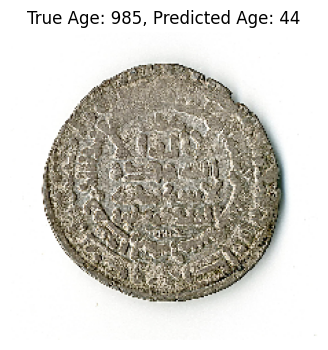

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to load and predict a single image
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    return pred[0][0], img

# Select a few test images from your DataFrame (adjust indices as needed)
sample_images = test_df['Image'].head(5).tolist()
true_ages = test_df['Age'].head(5).tolist()

for i, img_path in enumerate(sample_images):
    pred_age, img = predict_image(img_path, model)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"True Age: {true_ages[i]:.0f}, Predicted Age: {pred_age:.0f}")
    plt.axis('off')
    plt.show()


In [9]:
from tensorflow.keras.models import load_model
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = load_model("final_artifact_date_model.keras")

# Set up a generator for your test dataset (make sure your test CSV is set up similarly)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,            # your test dataframe
    x_col="Image",                # adjust if needed
    y_col="Age",
    directory="",                # or set appropriate directory if relative paths
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

results = model.evaluate(test_generator)
print("Test Loss:", results[0])
print("Test MAE:", results[1])


Found 186 validated image filenames.
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 765659.6250 - mae: 846.2949
Test Loss: 791674.9375
Test MAE: 862.8797607421875


In [12]:
import pandas as pd
import os
import re
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Read the CSV
CSV_PATH = 'artifact_dataset/metadata.csv'
df = pd.read_csv(CSV_PATH)

# Clean columns
df['ArtifactType'] = df['ArtifactType'].str.strip()
df['Name'] = df['Name'].str.strip()
df['Age'] = df['Age'].str.strip()
df['Image'] = df['Image'].str.strip()

# Assume the Image column contains relative paths like "artifact_dataset/images/coin/457172.jpg"
# If needed, adjust paths accordingly.
# Parse Age column (update this function as needed)
def parse_age(age_str):
    if isinstance(age_str, str):
        match_range = re.match(r'(\d+)-(\d+)\s*(AD|BCE)?', age_str)
        if match_range:
            start, end, era = match_range.groups()
            start, end = int(start), int(end)
            return (start + end) / 2.0
        match_single = re.match(r'(?:AD|BCE)?\s*(\d+)', age_str)
        if match_single:
            return float(match_single.group(1))
    return None

df['Age'] = df['Age'].apply(parse_age)

# Filter rows with valid age and image paths
df = df[df['Age'].notna()]
df = df[df['Image'].apply(lambda x: os.path.exists(x))]

# Scale Age values
scaler = MinMaxScaler()
df['Age_scaled'] = scaler.fit_transform(df[['Age']])

# Save cleaned dataframe if desired
df.to_csv("cleaned_dataset.csv", index=False)

# Data generator (using the full paths in the 'Image' column)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 20

# Use "Age_scaled" as target
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="Image",
    y_col="Age_scaled",
    directory='',  # because Image column has full/relative paths
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset="training",
    class_mode='raw'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="Image",
    y_col="Age_scaled",
    directory='',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset="validation",
    class_mode='raw'
)

# Build model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='linear')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mean_squared_error',
              metrics=['mae'])
model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("artifact_date_model.keras", monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Fine-tuning: unfreeze last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='mean_squared_error',
              metrics=['mae'])

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

model.save("final_artifact_date_model.keras")
print("Training complete. Final model saved as final_artifact_date_model.keras")



Found 741 validated image filenames.
Found 185 validated image filenames.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - loss: 2.9346 - mae: 1.4082 - val_loss: 0.6630 - val_mae: 0.7953
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 2.0069 - mae: 1.1589 - val_loss: 0.1846 - val_mae: 0.3969
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 1.8382 - mae: 1.0831 - val_loss: 0.0529 - val_mae: 0.1900
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 1.3254 - mae: 0.9165 - val_loss: 0.0391 - val_mae: 0.1523
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 1.2425 - mae: 0.8986 - val_loss: 0.0354 - val_mae: 0.1438
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 1.2724 - mae: 0.9009 - val_loss: 0.0357 - val_mae: 0.1378
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 1.2180 - mae: 0.8888 - val_loss: 0.0316 - val_mae: 0.1320
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 1.0041 - mae: 0.7971 - val_loss: 0.0299 - val_mae: 0.1263
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 0.9294 - mae: 0.7830 - va

AttributeError: 'Image' object has no attribute 'astype'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
True Age: 945.0, Predicted Age: 1387.400390625


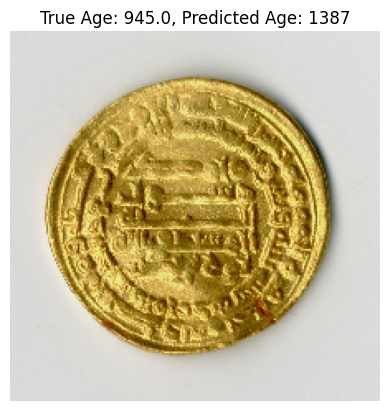

In [15]:

# When evaluating or making predictions, remember to invert the scaling:
# Example for a single image:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred_scaled = model.predict(img_array)
    # Inverse transform to get original age value
    pred_age = scaler.inverse_transform(pred_scaled)
    return pred_age[0][0], img  # Returning PIL Image object

# Test on a sample image
sample_img = df['Image'].iloc[0]
predicted_age, img_display = predict_image(sample_img)
print(f"True Age: {df['Age'].iloc[0]}, Predicted Age: {predicted_age}")

# Convert PIL Image to NumPy array for plotting
img_display_np = np.array(img_display)

plt.imshow(img_display_np.astype('uint8'))
plt.title(f"True Age: {df['Age'].iloc[0]}, Predicted Age: {predicted_age:.0f}")
plt.axis('off')
plt.show()